In [1]:
#==========Imports==========
import numpy as np
import matplotlib.pyplot as plt
import astropy.constants as const
import time
from scipy import interpolate
import Zach_OPTIMIZER.EBMFunctions as opt

import Bell_EBM as ebm

In [2]:
#==========Set Up System==========
planet = ebm.Planet(rad=1.500*const.R_jup.value, mass=1.170*const.M_jup.value,
                    Porb=1.09142030, a=0.02340*2*const.au.value, inc=83.37, vWind=5e3, nlat = 8, e=0.2)
star = ebm.Star(teff=6300., rad=1.59, mass=1.20)
system = ebm.System(star, planet)

In [8]:
def CreateBaseline(star, planet, temporal=5000, spacial=32,orbit=2):
    _star = star
    _planet = planet
    _system = ebm.System(_star, _planet)
    
    Teq = _system.get_teq()
    T0 = np.ones_like(_system.planet.map.values)*Teq
    t0 = 0.
    t1 = t0+_system.planet.Porb*orbit
    dt = _system.planet.Porb/temporal
    baselineTimes, baselineMaps = _system.run_model(T0, t0, t1, dt, verbose=False, intermediates=False)
    if (planet.orbit.e != 0.):
        T0 = baselineMaps[-1]
        t0 = baselineTimes[-1]
        t1 = t0+system.planet.Porb
        dt = (system.planet.Porb)/1000.
        baselineTimes, baselineMaps = system.run_model(T0, t0, t1, dt, verbose=False, intermediates=True)
        
        baselineLightcurve = system.lightcurve(baselineTimes, baselineMaps, bolo=False, wav=4.5e-6)
        
#         phaseBaseline = system.get_phase(baselineTimes).flatten()
#         order = np.argsort(phaseBaseline)
#         baselineLightcurve = baselineLightcurve[order]
#         phaseBaseline = phaseBaseline[order]
    else:
        baselineLightcurve = system.lightcurve(bolo=False, wav=4.5e-6)
    
    return baselineTimes, baselineMaps, baselineLightcurve

In [3]:
blt, blm, blc = opt.CreateBaseline(star,planet)

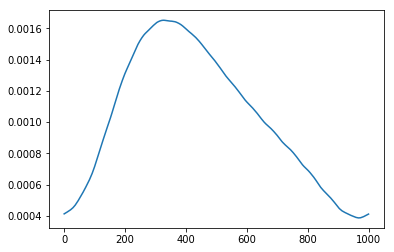

In [4]:
plt.plot(blc)

In [17]:
def RunTests(star, planet, points, base):
    data = np.zeros(shape=(points.shape[0],4))
    _star = star
    _planet = planet
    _system = ebm.System(_star,_planet)
    for i in range(0, points.shape[0]):
        
        _star = star
        _planet = planet        
        _planet.map = ebm.Map.Map(nlat=points[i,1])
        _system = ebm.System(_star, _planet)
        
        data[i,0] = points[i,0]
        data[i,1] = points[i,1]
        
        tInt = time.time()
        
        Teq = _system.get_teq()
        T0 = np.ones_like(_system.planet.map.values)*Teq
        t0 = 0.
        t1 = t0+_system.planet.Porb
        dt = _system.planet.Porb/points[i,0]
        testTimes, testMaps = system.run_model(T0, t0, t1, dt, verbose=False)
        if (_planet.orbit.e != 0):
            T0 = testMaps[-1]
            t0 = testTimes[-1]
            t1 = t0+_system.planet.Porb
            dt = system.planet.Porb/points[i,0]
            testTimes, testMaps = system.run_model(T0, t0, t1, dt, verbose=False, intermediates=True)
            testLightcurve = system.lightcurve(testTimes, testMaps, bolo=False, wav=4.5e-6)
            
            phaseTest = _system.get_phase(testTimes).flatten()
            order = np.argsort(phaseTest)
            testLightcurve = testLightcurve[order]
            phaseTest = phaseTest[order]
            testLightcurve = np.interp(base, phaseTest, testLightcurve)
        else:
            testLightcurve = system.lightcurve(bolo=False, wav=4.5e-6)

        tFin = time.time()
        
        data[i,3] = (1e6)*(np.amax(np.absolute(base - testLightcurve)))
        data[i,2] = (tFin - tInt)*(1e3)

    return testLightcurve, data


In [6]:
p = np.zeros(shape=((10),2))

In [7]:
p[:,0]=500
p[:,1]=8
p[9,0] = 500
p[9,1] = 8

In [8]:
p

array([[500.,   8.],
       [500.,   8.],
       [500.,   8.],
       [500.,   8.],
       [500.,   8.],
       [500.,   8.],
       [500.,   8.],
       [500.,   8.],
       [500.,   8.],
       [500.,   8.]])

In [9]:
lc, data = opt.RunTests(star,planet,p,blc,blt)

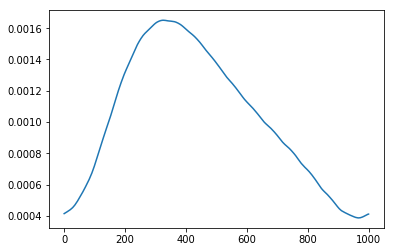

In [10]:
plt.plot(lc)

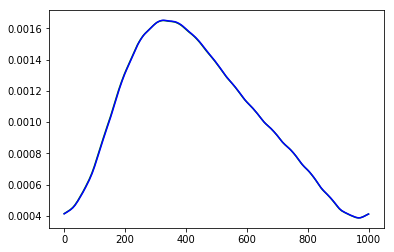

In [11]:
plt.plot(lc, c='g')
plt.plot(blc, c='b')

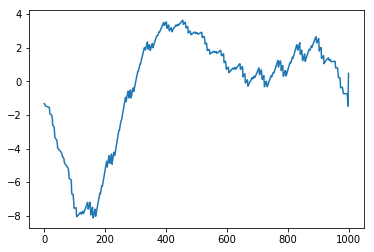

In [14]:
plt.plot((blc-lc)*(1e6))

In [63]:
def Optimize(star, planet, error, verbose=False):
    _planet = planet
    _star = star
    aError = error

    #==========High Res Baseline Creation==========    
    if (verbose == True): 
        print("Starting baseline generation...")
    
    tInt = time.time()
    blt, blm, blc = CreateBaseline(_star, _planet)
    tFin = time.time()
    
    if (verbose == True): 
        print("Baseline generation complete; Time to Compute: " + str(round(tFin-tInt,2)) + "s")

    #===========Initial data creationg================
    space_points = 5
    temp_points = 5
    data = np.zeros(shape=((space_points*temp_points),4))
    for i in range (0, temp_points):
        for j in range (0, space_points):
            data[(i*space_points)+j,0]= ((i+1)*250)+0
            data[(i*space_points)+j,1] = ((j+1)*4)+0
    if (verbose == True): 
        print("First pass data points assigned")

    #==================First pass testing Area======================
    if (verbose == True): 
        print("Starting first pass...")
        
    tInt = time.time()
    lc, data = RunTests(_star, _planet, data, blc)
    tFin = time.time()
    
    if (verbose == True): 
        print("First pass finished : Time to compute: " + str(round(tFin-tInt,2)) + "s")

    #=================First pass best point===================
    #print(data) #For debugging purposes 
    if (verbose == True):
        print("Processing first pass data...")
    iBest = None
    for i in range(0,space_points*temp_points):
        if (data[i,3]<=(aError*1.05)):
            if (iBest == None):
                iBest = i
            if(data[i,2] < data[iBest,2]):
                iBest = i
                
    #===========Second pass data creation================
    space_points = 5
    temp_points = 5
    dataDouble = np.zeros(shape=((space_points*temp_points),2))
    for i in range (0, temp_points):
        for j in range (0, space_points):
            dataDouble[(i*space_points)+j,0] = ((i)*50)+(data[iBest,0]-100)
            if (dataDouble[(i*space_points)+j,0]<100):
                dataDouble[(i*space_points)+j,0] = 100
            dataDouble[(i*space_points)+j,1] = ((j)*2)+(data[iBest,1]-4)
            if (dataDouble[(i*space_points)+j,1]<2):
                dataDouble[(i*space_points)+j,1] = 2
    if (verbose == True): 
        print("Second pass data points assigned")
    
    #==================Second pass testing Area======================
    if (verbose == True): 
        print("Starting second pass...")
        
    tInt = time.time()
    lc, dataDouble = RunTests(_star, _planet, dataDouble, blc)
    tFin = time.time()
    if (verbose == True): 
        print("Second pass finished : Time to compute: " + str(round(tFin-tInt,2)) + "s")
    
    #=================Finding best second pass point===================
    #print(data) #For debugging purposes 
    if (verbose == True):
        print("Processing second pass data...")
    iBest = None
    for i in range(0,space_points*temp_points):
        if (dataDouble[i,3]<=aError):
            if (iBest == None):
                iBest = i
            if(dataDouble[i,2] < dataDouble[iBest,2]):
                iBest = i

    if (iBest == None):
        print("No points match requested error")
    else:
        print("Temporal: " + str(dataDouble[iBest,0]) + " Spacial: " + str(dataDouble[iBest,1]))
        print("Time for compute: " + str(round(dataDouble[iBest, 2],2)) +"ms : Error: " + str(round(dataDouble[iBest, 3],2)) + "ppm")
        print("Expected compute time @ 1,000,000 cycles: " + str((round((dataDouble[iBest, 2]*1e3/60)/60,2))) + " Hrs")
       
    return dataDouble[iBest,0], dataDouble[iBest,1]
#     #print(data) #For debugging
#     #print(dataDouble) #For debugging
#     #=========Create Maps==================
#     if (verbose == True):
#         planet.map = ebm.Map.Map(nlat=dataDouble[iBest,1])
#         system = ebm.System(star, planet)

#         TotalTimeToCompute = 0.

#         Teq = system.get_teq()
#         T0 = np.ones_like(system.planet.map.values)*Teq
#         t0 = 0.
#         t1 = t0+system.planet.Porb*1
#         dt = system.planet.Porb/dataDouble[iBest,0]
#         times, maps, ttc = system.run_model_tester(T0, t0, t1, dt, verbose=False)
#         TotalTimeToCompute += ttc

#         if (planet.orbit.e != 0):
#             T0 = maps[-1]
#             t0 = times[-1]
#             t1 = t0+system.planet.Porb
#             dt = system.planet.Porb/dataDouble[iBest,0]
#             times, maps, ttc = system.run_model_tester(T0, t0, t1, dt, verbose=False, intermediates=True)
#             TotalTimeToCompute += ttc

#         testLightcurve = system.lightcurve(times, maps, bolo=False, wav=4.5e-6)

#         phaseTest = system.get_phase(times).flatten()
#         order = np.argsort(phaseTest)
#         testLightcurve = testLightcurve[order]
#         phaseTest = phaseTest[order]
#         testLightcurve = np.interp(phaseBaseline, phaseTest, testLightcurve)
        

#         plt.plot((baselineLightcurve)*1e6, lw=2, c='g')
#         plt.plot((testLightcurve)*1e6, lw=1, c='r')
#         plt.title("Lightcurves of baseline (green) compared to recommended values (red)")
#         plt.show()



In [12]:
temp, space = opt.Optimize(star, planet, 100, verbose=True)

Starting baseline generation...
Baseline generation complete; Time to Compute: 2.76s
First pass data points assigned
Starting first pass...
First pass finished : Time to compute: 25.06s
Processing first pass data...
Second pass data points assigned
Starting second pass...
Second pass finished : Time to compute: 3.04s
Processing second pass data...
Temporal: 150.0 Spacial: 6.0
Time for compute: 66.81ms : Error: 44.1ppm
Expected compute time @ 1,000,000 cycles: 18.56 Hrs


In [28]:
phaseBaseline = system.get_phase(blt).flatten()
order = np.argsort(phaseBaseline)
baselineLightcurve = blc[order]
phaseBaseline = phaseBaseline[order]


_star = star
_planet = planet        
_planet.map = ebm.Map.Map(nlat=8)
_system = ebm.System(_star, _planet)

tInt = time.time()

Teq = _system.get_teq()
T0 = np.ones_like(_system.planet.map.values)*Teq
t0 = 0.
t1 = t0+_system.planet.Porb
dt = _system.planet.Porb/500
testTimes, testMaps = system.run_model(T0, t0, t1, dt, verbose=False)
if (_planet.orbit.e != 0):
    T0 = testMaps[-1]
    t0 = testTimes[-1]
    t1 = t0+_system.planet.Porb
    dt = system.planet.Porb/500
    testTimes, testMaps = system.run_model(T0, t0, t1, dt, verbose=False, intermediates=True)
    testLightcurve = system.lightcurve(testTimes, testMaps, bolo=False, wav=4.5e-6)
    
    testbeta = testLightcurve
    
    phaseTest = _system.get_phase(testTimes).flatten()
    order = np.argsort(phaseTest)
    testLightcurve = testLightcurve[order]
    testalpha = testLightcurve
    phaseTest = phaseTest[order]
    testLightcurve = np.interp(phaseBaseline, phaseTest, testLightcurve)
else:
    testLightcurve = system.lightcurve(bolo=False, wav=4.5e-6)

tFin = time.time()



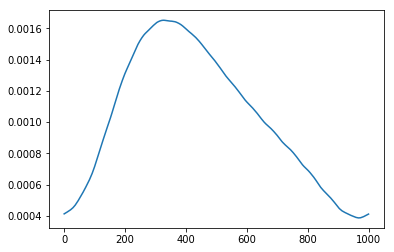

In [19]:
plt.plot(blc)

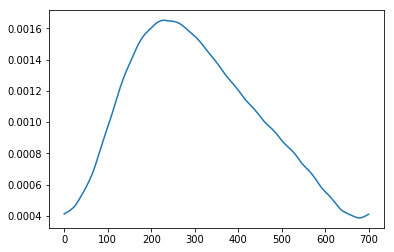

In [53]:
plt.plot(testbeta)

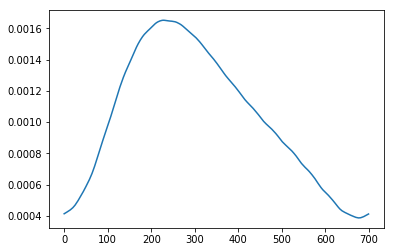

In [49]:
plt.plot(testalpha)

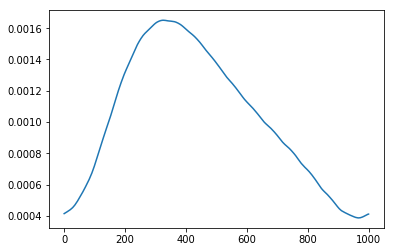

In [29]:
plt.plot(testLightcurve)

In [50]:
phaseTest

array([0.        , 0.00218702, 0.00437391, 0.00656051, 0.00874671,
       0.01093236, 0.01311732, 0.01530145, 0.01748463, 0.01966671,
       0.02184756, 0.02402705, 0.02620504, 0.0283814 , 0.03055599,
       0.03272869, 0.03489937, 0.0370679 , 0.03923414, 0.04139798,
       0.04355928, 0.04571792, 0.04787379, 0.05002675, 0.05217669,
       0.05432349, 0.05646704, 0.05860721, 0.06074389, 0.06287698,
       0.06500635, 0.06713191, 0.06925355, 0.07137115, 0.07348463,
       0.07559387, 0.07769878, 0.07979926, 0.08189521, 0.08398655,
       0.08607318, 0.08815501, 0.09023195, 0.09230393, 0.09437085,
       0.09643264, 0.09848922, 0.10054051, 0.10258643, 0.10462692,
       0.10666191, 0.10869132, 0.11071509, 0.11273316, 0.11474547,
       0.11675195, 0.11875255, 0.12074721, 0.12273589, 0.12471852,
       0.12669507, 0.12866548, 0.13062971, 0.13258772, 0.13453946,
       0.1364849 , 0.13842399, 0.14035672, 0.14228303, 0.14420291,
       0.14611631, 0.14802322, 0.14992361, 0.15181746, 0.15370

In [40]:
testTimes

array([[1.08986113],
       [1.0914203 ],
       [1.09297947],
       [1.09453864],
       [1.09609782],
       [1.09765699],
       [1.09921616],
       [1.10077533],
       [1.1023345 ],
       [1.10389367],
       [1.10545285],
       [1.10701202],
       [1.10857119],
       [1.11013036],
       [1.11168953],
       [1.11324871],
       [1.11480788],
       [1.11636705],
       [1.11792622],
       [1.11948539],
       [1.12104457],
       [1.12260374],
       [1.12416291],
       [1.12572208],
       [1.12728125],
       [1.12884042],
       [1.1303996 ],
       [1.13195877],
       [1.13351794],
       [1.13507711],
       [1.13663628],
       [1.13819546],
       [1.13975463],
       [1.1413138 ],
       [1.14287297],
       [1.14443214],
       [1.14599132],
       [1.14755049],
       [1.14910966],
       [1.15066883],
       [1.152228  ],
       [1.15378717],
       [1.15534635],
       [1.15690552],
       [1.15846469],
       [1.16002386],
       [1.16158303],
       [1.163

In [41]:
blt

array([[2.18262232],
       [2.18371374],
       [2.18480516],
       [2.18589658],
       [2.186988  ],
       [2.18807942],
       [2.18917084],
       [2.19026226],
       [2.19135368],
       [2.1924451 ],
       [2.19353652],
       [2.19462794],
       [2.19571936],
       [2.19681078],
       [2.1979022 ],
       [2.19899362],
       [2.20008504],
       [2.20117646],
       [2.20226788],
       [2.2033593 ],
       [2.20445072],
       [2.20554214],
       [2.20663356],
       [2.20772498],
       [2.2088164 ],
       [2.20990782],
       [2.21099924],
       [2.21209066],
       [2.21318208],
       [2.2142735 ],
       [2.21536492],
       [2.21645635],
       [2.21754777],
       [2.21863919],
       [2.21973061],
       [2.22082203],
       [2.22191345],
       [2.22300487],
       [2.22409629],
       [2.22518771],
       [2.22627913],
       [2.22737055],
       [2.22846197],
       [2.22955339],
       [2.23064481],
       [2.23173623],
       [2.23282765],
       [2.233

In [43]:
blt.shape

(1000, 1)

In [44]:
testTimes.shape

(700, 1)

In [53]:
def RunTests(star, planet, points, base, basetimes, basemap):
    """
    Runs several test of a system and returns time 
    to compute and error as comapared to baseline for each test.
    
    Args:
        star (ebm.Star): The star to runs the tests on
        planet (ebm.Planet): The planet to run the tests on
        points (2darray (n by 2)): The array of points to be tested by the model, 
            each point must contain [temporal, spacial], n points are provided
        base (ndarray): Baseline lightcurve as generated by the CreateBaseline function
        
    Return:
        ndarray: Latest tested lightcurve, mainly used for debugging purposes
        ndarray: (n by 4), n points of format [temporal, spacial, time_to_compute, error_in_ppm]
    """
    
    data = np.zeros(shape=(points.shape[0],4))
    _star = star
    _planet = planet
    _system = ebm.System(_star,_planet)
    
    if (_planet.orbit.e != 0):
        phaseBaseline = _system.get_phase(basetimes).flatten()
        order = np.argsort(phaseBaseline)
        baselineLightcurve = base[order]
        phaseBaseline = phaseBaseline[order]
        
    for i in range(0, points.shape[0]):
        
        _star = star
        _planet = planet        
        _planet.map = ebm.Map.Map(nlat=points[i,1])
        _system = ebm.System(_star, _planet)
        
        data[i,0] = points[i,0]
        data[i,1] = points[i,1]
        
        tInt = time.time()
        
        Teq = _system.get_teq()
        T0 = np.ones_like(_system.planet.map.values)*Teq
        t0 = 0.
        t1 = t0+_system.planet.Porb
        dt = _system.planet.Porb/points[i,0]
        testTimes, testMaps = _system.run_model(T0, t0, t1, dt, verbose=False)
#         if (_planet.orbit.e != 0):
#             T0 = testMaps[-1]
#             t0 = testTimes[-1]
#             t1 = t0+_system.planet.Porb
#             dt = _system.planet.Porb/points[i,0]
#             testTimes, testMaps = _system.run_model(T0, t0, t1, dt, verbose=False, intermediates=True)
#             testLightcurve = _system.lightcurve(testTimes, testMaps, bolo=False, wav=4.5e-6)
            
#             phaseTest = _system.get_phase(testTimes).flatten()
#             order = np.argsort(phaseTest)
#             testLightcurve = testLightcurve[order]
#             phaseTest = phaseTest[order]
#             testLightcurve = np.interp(phaseBaseline, phaseTest, testLightcurve)
#         else:
#             testLightcurve = _system.lightcurve(bolo=False, wav=4.5e-6)
        if (_planet.orbit.e != 0):
            T0 = testMaps[-1]
            t0 = testTimes[-1]
            t1 = t0+_system.planet.Porb
            dt = system.planet.Porb/points[i,0]
            testTimes, testMaps = _system.run_model(T0, t0, t1, dt, verbose=False, intermediates=True)
            testLightcurve = _system.lightcurve(testTimes, testMaps, bolo=False, wav=4.5e-6)

            #testbeta = testLightcurve

            phaseTest = _system.get_phase(testTimes).flatten()
            order = np.argsort(phaseTest)
            testLightcurve = testLightcurve[order]
            #testalpha = testLightcurve
            phaseTest = phaseTest[order]
            testLightcurve = np.interp(phaseBaseline, phaseTest, testLightcurve)
        else:
            testLightcurve = system.lightcurve(bolo=False, wav=4.5e-6)

        tFin = time.time()
        
        data[i,3] = (1e6)*(np.amax(np.absolute(base - testLightcurve)))
        data[i,2] = (tFin - tInt)*(1e3)

    return testLightcurve, data

In [54]:
light, ded = RunTests(star,planet,p,blc,blt,blm)

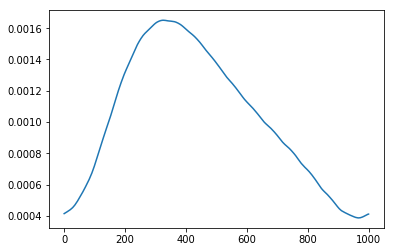

In [55]:
plt.plot(light)

In [ ]:
phaseBaseline = system.get_phase(blt).flatten()
order = np.argsort(phaseBaseline)
baselineLightcurve = blc[order]
phaseBaseline = phaseBaseline[order]
